In [2]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [3]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger
import nersc_tensorboard_helper

sys.path.append('..')
device = "cuda" if torch.cuda.is_available() else "cpu"


In [5]:
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding

In [17]:
run_name = "high_warmup"
with open("example_embedding.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
model = LayerlessEmbedding(hparams)
model.setup(stage="fit")

In [18]:
from pytorch_lightning import Trainer
logger = TensorBoardLogger("tb_logs",name = "embedding_"+run_name)
trainer = Trainer(gpus=1, max_epochs=10,logger = logger)
trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type       | Params
-----------------------------------------
0 | layers    | ModuleList | 13.3 K
1 | emb_layer | Linear     | 520   
2 | norm      | LayerNorm  | 128   
3 | act       | Tanh       | 0     
-----------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/j/jferguso/.conda/envs/exatrkx-tracking/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s]

../LightningModules/Embedding/embedding_base.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(cluster_true_positive / cluster_true)
../LightningModules/Embedding/embedding_base.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(cluster_true_positive / cluster_positive)


Epoch 0:   0%|          | 0/120 [00:00<?, ?it/s]                      

/global/homes/j/jferguso/.conda/envs/exatrkx-tracking/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  83%|████████▎ | 100/120 [00:20<00:04,  4.83it/s, loss=0.889, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|████████▎ | 100/120 [00:20<00:04,  4.85it/s, loss=0.827, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|████████▎ | 100/120 [00:19<00:03,  5.07it/s, loss=0.678, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|████████▎ | 100/120 [00:18<00:03,  5.28it/s, loss=0.634, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|████████▎ | 100/120 [00:18<00:03,  5.48it/s, loss=0.574, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 5:  83%|████████▎ | 100/120 [00:17<00:03,  5.57it/s, loss=0.534, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|████████▎ | 100/120 [00:17<00:03,  5.66it/s, loss=0.493, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 7:  83%|████████▎ | 100/120 [00:17<00:03,  5.67it/s, loss=0.421, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|████████▎ | 100/120 [00:17<00:03,  5.76it/s, loss=0.399, v_num=1]
Validating: 0it [00:00, ?it/s]
E

1

In [19]:
test_results = trainer.test(ckpt_path=None)
from LightningModules.Embedding.utils import get_metrics
model.eval();

Set SLURM handle signals.


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

/global/homes/j/jferguso/.conda/envs/exatrkx-tracking/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 0.9735673069953918,
 'preds': array([[    0,     0,     0, ..., 12150, 12150, 12150],
       [  686,  1012,  1087, ..., 11810, 11812, 11813]]),
 'truth': array([False,  True,  True, ...,  True,  True,  True]),
 'truth_graph': array([[  103,   103,   179, ..., 11070, 11463, 11463],
       [  706,   760,   706, ...,  9935, 11067, 11070]])}
--------------------------------------------------------------------------------


In [20]:
all_efficiencies, all_purities = [], []
all_radius = np.arange(0.5, 1.2, 0.1)

with torch.no_grad():
    for r in all_radius:

        model.hparams.r_test = r
        test_results = trainer.test(ckpt_path=None)

        mean_efficiency, mean_purity = get_metrics(test_results, model)

        all_efficiencies.append(mean_efficiency)
        all_purities.append(mean_purity)

Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

Set SLURM handle signals.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 0.7036618590354919,
 'preds': array([[    0,     1,     1, ..., 12150, 12150, 12150],
       [ 1012,     4,  1114, ..., 11810, 11812, 11813]]),
 'truth': array([ True, False,  True, ...,  True,  True,  True]),
 'truth_graph': array([[  103,   103,   179, ..., 11070, 11463, 11463],
       [  706,   760,   706, ...,  9935, 11067, 11070]])}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

Set SLURM handle signals.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 0.7376210689544678,
 'preds': array([[    0,     0,     1, ..., 12150, 12150, 12150],
       [ 1012,  1087,     4, ..., 11810, 11812, 11813]]),
 'truth': array([ True,  True, False, ...,  True,  True,  True]),
 'truth_graph': array([[  103,   103,   179, ..., 11070, 11463, 11463],
       [  706,   760,   706, ...,  9935, 11067, 11070]])}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s]

Set SLURM handle signals.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 0.7927619814872742,
 'preds': array([[    0,     0,     1, ..., 12150, 12150, 12150],
       [ 1012,  1087,     4, ..., 11810, 11812, 11813]]),
 'truth': array([ True,  True, False, ...,  True,  True,  True]),
 'truth_graph': array([[  103,   103,   179, ..., 11070, 11463, 11463],
       [  706,   760,   706, ...,  9935, 11067, 11070]])}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]

Set SLURM handle signals.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 0.8437907099723816,
 'preds': array([[    0,     0,     0, ..., 12150, 12150, 12150],
       [ 1012,  1087,  2020, ..., 11810, 11812, 11813]]),
 'truth': array([ True,  True, False, ...,  True,  True,  True]),
 'truth_graph': array([[  103,   103,   179, ..., 11070, 11463, 11463],
       [  706,   760,   706, ...,  9935, 11067, 11070]])}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]

Set SLURM handle signals.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 0.8856512904167175,
 'preds': array([[    0,     0,     0, ..., 12150, 12150, 12150],
       [ 1012,  1087,  2020, ..., 11810, 11812, 11813]]),
 'truth': array([ True,  True, False, ...,  True,  True,  True]),
 'truth_graph': array([[  103,   103,   179, ..., 11070, 11463, 11463],
       [  706,   760,   706, ...,  9935, 11067, 11070]])}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]

Set SLURM handle signals.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 0.9169003963470459,
 'preds': array([[    0,     0,     0, ..., 12150, 12150, 12150],
       [ 1012,  1087,  2020, ..., 11810, 11812, 11813]]),
 'truth': array([ True,  True, False, ...,  True,  True,  True]),
 'truth_graph': array([[  103,   103,   179, ..., 11070, 11463, 11463],
       [  706,   760,   706, ...,  9935, 11067, 11070]])}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 0.9368391036987305,
 'preds': array([[    0,     0,     0, ..., 12150, 12150, 12150],
       [ 1012,  1087,  1341, ..., 11810, 11812, 11813]]),
 'truth': array([ True,  True, False, ...,  True,  True,  True]),
 'truth_graph': array([[  103,   103,   179, ..., 11070, 11463, 11463],
       

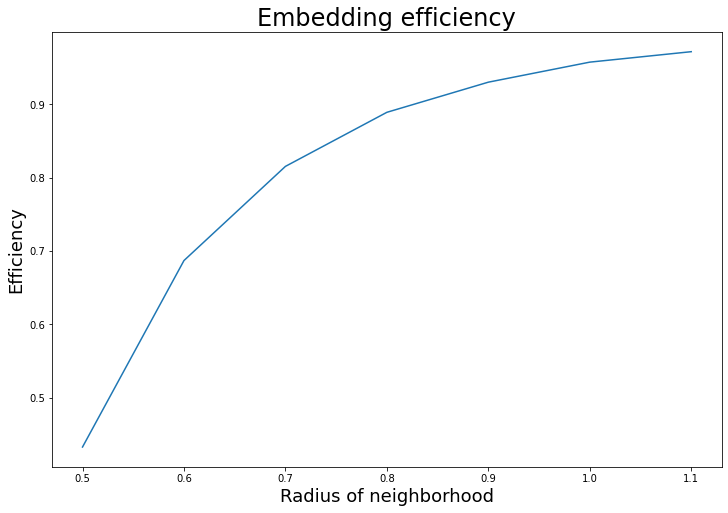

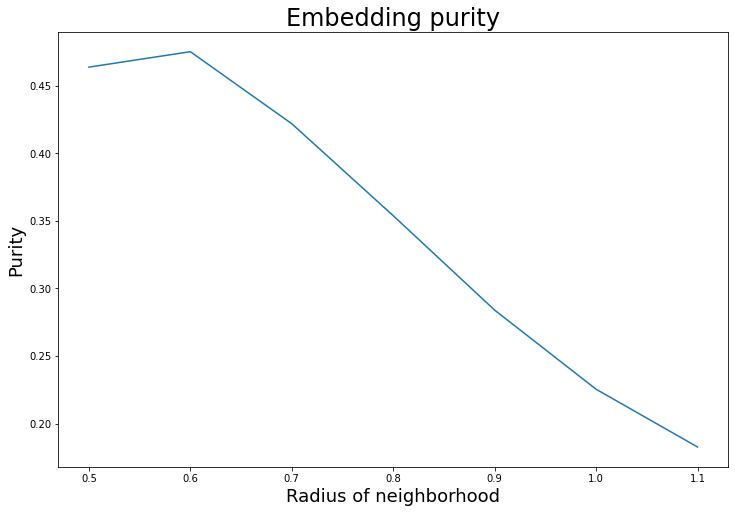

In [21]:

plt.figure(figsize=(12,8))
plt.plot(all_radius, all_efficiencies);
plt.title("Embedding efficiency", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Efficiency", fontsize=18);
plt.savefig(run_name + "_eff.png")
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_purities);
plt.title("Embedding purity", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Purity", fontsize=18);
plt.savefig(run_name + "_purity.png")

In [22]:
os.environ['TENSORBOARD_BINARY'] = "/global/homes/j/jferguso/.conda/envs/exatrkx-tracking/bin/tensorboard"
%tensorboard --logdir tb_logs/ --port 0
nersc_tensorboard_helper.tb_address()